# Active learning for Binary Classification

Not all data is created equal. In many cases, the cost of labeling data is high, and the number of labeled data is limited. Active learning is a semi-supervised learning method that aims to reduce the cost of labeling data by selecting the most informative data points to be labeled. In this notebook, we will explore the active learning process, starting from binary classification using 2d data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)  ### REMOVE!

cluster1 = np.random.normal((-2, 0), (1, 1), (100, 2))
cluster2 = np.random.normal((2, 0), (1, 1), (100, 2))

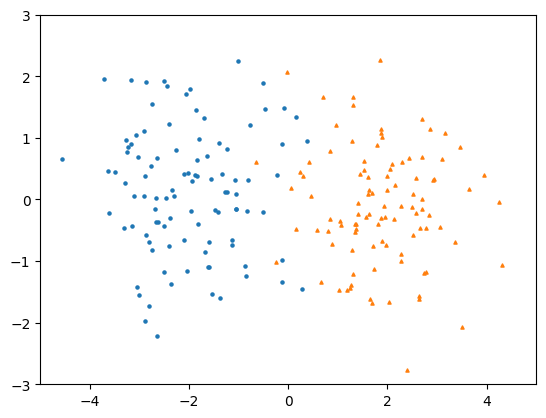

In [2]:
plt.scatter(cluster1[:, 0], cluster1[:, 1], marker="o", s=5, c="C0")
plt.scatter(cluster2[:, 0], cluster2[:, 1], marker="^", s=5, c="C1")
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.show()

We'll use a simple logistic regression model instead of a neural network to keep the focus on the active learning process. First, we check how well the model performs on the full dataset.

In [3]:
from sklearn.linear_model import LogisticRegression

x = np.vstack((cluster1, cluster2))
y = np.hstack((np.zeros(len(cluster1)), np.ones(len(cluster2))))

def train_model(x_train, y_train, x_test, y_test):
    """Find optimal decision boundary using a logistic regression model."""
    model = LogisticRegression()
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    return model, accuracy

model, full_accuracy = train_model(x, y, x, y)

print(f'Accuracy: {full_accuracy}')

Accuracy: 0.97


We now define the active learning process as follows:
1. Annotate a small seed dataset. Here we will pick one random data point from each class. In a real-world scenario, this is usually a small randomlly selected subset of the full dataset.
2. Train the model on the annotated dataset.
3. Use a query strategy to select the most informative data points from the unannotated dataset.
4. Annotate the selected data points and add them to the annotated dataset.
5. Repeat steps 2-4 until the model performance converges or the budget for labeling data is exhausted.

In [4]:
def train_active_learning(x, y, budget, query):
    """Train model with active learning."""
    annotated_data_idxs = np.array([], dtype=int)  ### seed with 1 positive and 1 negative example
    for i in range(int(y.max()) + 1):
        idx = np.random.choice(np.where(y == i)[0])
        annotated_data_idxs = np.append(annotated_data_idxs, idx)
    other_data_idxs = np.setdiff1d(np.arange(x.shape[0]), annotated_data_idxs)

    accuracy_history = []
    for _ in range(budget):
        annotated_data = x[annotated_data_idxs]
        annotations = y[annotated_data_idxs]
        other_data = x[other_data_idxs]

        model, accuracy = train_model(annotated_data, annotations, x, y)
        accuracy_history.append(accuracy)
        
        idx_to_annotate = query(model, other_data)
        idx_in_x = other_data_idxs[idx_to_annotate]
        annotated_data_idxs = np.append(annotated_data_idxs, idx_in_x)
        other_data_idxs = np.delete(other_data_idxs, idx_to_annotate)

    return accuracy_history, model, annotated_data_idxs

First, we test what happens if we use random query strategy.

In [5]:
def query_random(model, x):
    """Select data point to annotate randomly."""
    return np.random.choice(len(x))

accuracy_history_random, model_random, annotated_data_idxs_random = \
    train_active_learning(x, y, budget=25, query=query_random)

print(f"Accuracy random: {accuracy_history_random[-1] * 100}%")

Accuracy random: 97.0%


We highlight the selected data points, and draw the final decision boundary of the model. We see that most points are sampled in the center of the clusters, and the decision boundary is not very accurate.

In [6]:
def plot_model(model, cluster1, cluster2, annotated_x, annotated_y):
    """Plot model performance and annotated data."""
    plt.scatter(cluster1[:, 0], cluster1[:, 1], marker="o", s=0.5, c="C0")
    plt.scatter(cluster2[:, 0], cluster2[:, 1], marker="^", s=0.5, c="C1")

    plt.scatter(annotated_x[~annotated_y, 0], annotated_x[~annotated_y, 1], 
                marker="o", s=100, c="C0", label="Selected Cluster 1")
    plt.scatter(annotated_x[annotated_y, 0], annotated_x[annotated_y, 1], 
                marker="^", s=100, c="C1", label="Selected Cluster 2")

    beta_1, beta_2 = model.coef_[0]
    intercept = model.intercept_
    boundary_x = np.linspace(-5, 5, 100)
    boundary_y = (- intercept - beta_1 * boundary_x) / beta_2
    plt.plot(boundary_x, boundary_y, c="black", label='Decision Boundary')

    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()

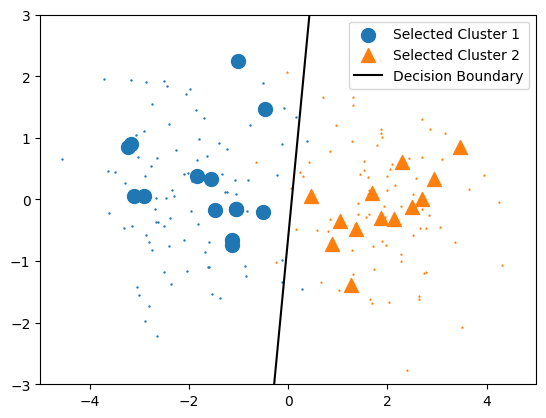

In [7]:
plot_model(model_random, cluster1, cluster2, 
           annotated_x=x[annotated_data_idxs_random], 
           annotated_y=y[annotated_data_idxs_random].astype(bool))

We now use a more informative query strategy, uncertainty sampling. This strategy selects the data points for which the model is most uncertain about the prediction. 

In [8]:
def query_us(model, x):
    """Select data point to annotate randomly with uncertainty sampling."""    
    probabilities = model.predict_proba(x)
    return np.argmin(np.abs(probabilities[:, 0] - 0.5))

accuracy_history_us, model_us, annotated_data_idxs_us = \
    train_active_learning(x, y, budget=25, query=query_us)
    
print(f"Accuracy uncertainty sampling: {accuracy_history_us[-1] * 100}%")

Accuracy uncertainty sampling: 96.5%


We see that all datapoints are sampled near the decision boundary.

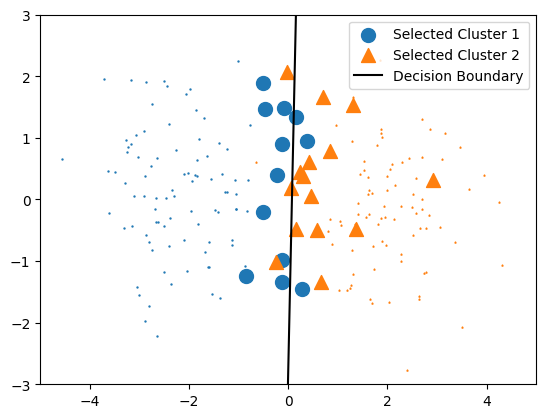

In [9]:
plot_model(model_us, cluster1, cluster2, 
           annotated_x=x[annotated_data_idxs_us], 
           annotated_y=y[annotated_data_idxs_us].astype(bool))

Due to the stochastic nature of random sampling, the results may vary. We will conduct 50 experiments for each query strategy and compare the results.

In [10]:
budget = 25
trials = 50

results_random = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(x, y, budget, query_random)
    results_random.append(accuracy_history)


In [11]:
results_us = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(x, y, budget, query_us)
    results_us.append(accuracy_history)

We see that the uncertainty sampling strategy converges faster and achieves better performance than the random sampling strategy.

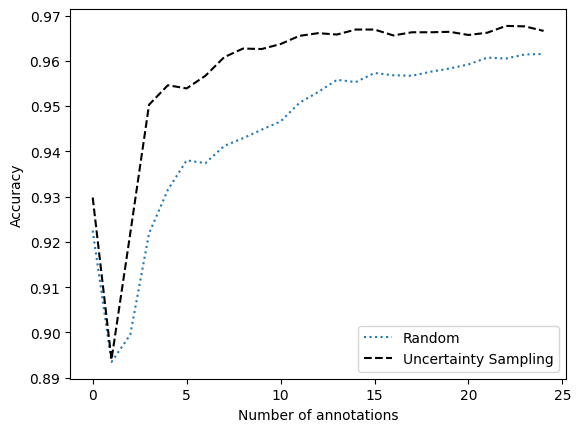

In [12]:
plt.plot(np.mean(results_random, axis=0), ":", label="Random")
plt.plot(np.mean(results_us, axis=0), "k--", label="Uncertainty Sampling")
plt.xlabel('Number of annotations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Multiclass Active Learning

When moving to multiclass classification, the concept of uncertainty becomes more complex. In binary classification, the uncertainty is a single value, but in multiclass classification, the uncertainty is a vector of values There are now several ways to measure uncertainty, and the choice of uncertainty measure can have a significant impact on the performance of the active learning algorithm. The most common uncertainty measures are:
- Entropy
- Margin (Largest or Smallest Margin)
- Least Confidence

We can visualize these measures using three classes in 2d space.

In [ ]:
import matplotlib.tri as tri

# triangle corners
tx = [0, 0.5, 1]
ty = [0, np.sqrt(3)/2, 0]
corners = np.array([[tx[0], ty[0]], [tx[1], ty[1]], [tx[2], ty[2]]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
heatmap_trimesh = refiner.refine_triangulation(subdiv=6)
grid_trimesh = refiner.refine_triangulation(subdiv=2)
x, y = heatmap_trimesh.x, heatmap_trimesh.y

# Convert cartesian coordinates to barycentric
T = np.array([[tx[0] - tx[2], tx[1] - tx[2]], [ty[0] - ty[2], ty[1] - ty[2]]])
T_inv = np.linalg.inv(T)
x1, x2 = np.dot(T_inv, np.array([x - tx[2], y - ty[2]]))
x3 = 1 - x1 - x2

r = np.array([x1, x2, x3])
confidence = np.max(r, axis=0)
large_margin = np.max(r, axis=0) - np.sort(r, axis=0)[0]
small_margin = np.max(r, axis=0) - np.sort(r, axis=0)[1]
entropy = -np.sum(r * np.log(r + 1e-5), axis=0)

def plot_measure(ax, measure, title):
    ax.tricontourf(heatmap_trimesh, measure, cmap='seismic', levels=50)
    ax.triplot(grid_trimesh, 'k--', lw=0.5)
    ax.axis('equal')
    ax.axis("off")
    ax.text(-0.06, -0.03, '0', ha='center', va='center', fontsize=12)
    for i in range(1, 5):
        _x = i / 8
        _y = np.sqrt(3) * i / 8
        ax.text(_x * 2, -0.05,  f'{i/4}', ha='center', va='center', fontsize=12)
        ax.text(_x - 0.05, _y, f'{i/4}', ha='right', va='center', fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.set_title(title)
    plt.colorbar(ax.collections[0], ax=ax, orientation='horizontal', format='%.2f')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_measure(axs[0], 1 - confidence, 'Least Confidence')
plot_measure(axs[1], 1 - small_margin, 'Smallest Margin')
plot_measure(axs[2], 1 - large_margin, 'Large Margin')
plot_measure(axs[3], entropy, 'Entropy')
plt.show()


Let us compare these measures using a simple example.

In [ ]:
cluster1 = np.random.normal(0, 0.75, (150, 2)) - (2, 0)
cluster2 = np.random.normal(0, 0.75, (150, 2)) + (2, 0)
cluster3 = np.random.normal(0, 0.75, (150, 2)) + (0, np.sqrt(3))

plt.scatter(cluster1[:, 0], cluster1[:, 1], marker='o', s=5)
plt.scatter(cluster2[:, 0], cluster2[:, 1], marker='^', s=5)
plt.scatter(cluster3[:, 0], cluster3[:, 1], marker='s', s=5)

In [ ]:
def query_uncertainty(model, x):
    probabilities = model.predict_proba(x)
    return np.argmin(np.max(probabilities, axis=1))

def query_small_margin(model, x):
    probabilities = model.predict_proba(x)
    sorted_probabilities = np.sort(probabilities, axis=1)
    margins = sorted_probabilities[:, -1] - sorted_probabilities[:, -2]
    return np.argmin(margins)

def query_large_margin(model, x):
    probabilities = model.predict_proba(x)
    margins = np.max(probabilities, axis=1) - np.min(probabilities, axis=1)
    return np.argmin(margins)

def query_entropy(model, x):
    probabilities = model.predict_proba(x)
    return np.argmax(-np.sum(probabilities * np.log(probabilities + 1e-5), axis=1))

X = np.vstack((cluster1, cluster2, cluster3))
y = np.hstack((np.zeros(len(cluster1)), np.ones(len(cluster2)), 2 * np.ones(len(cluster3))))

In [ ]:
accuracy, model, indices = train_active_learning(X, y, 30, query_random)
print(f'Accuracy random: {accuracy[-1] * 100}%')

In [ ]:
def plot_decision_boundary(model, X, y, indices):
    plt.scatter(cluster1[:, 0], cluster1[:, 1], marker='o', s=1, c="C0")
    plt.scatter(cluster2[:, 0], cluster2[:, 1], marker='^', s=1, c="C1")
    plt.scatter(cluster3[:, 0], cluster3[:, 1], marker='s', s=1, c="C2")

    annotated_X = X[indices]
    annotated_y = y[indices]

    is1 = annotated_y == 0
    is2 = annotated_y == 1
    is3 = annotated_y == 2
    plt.scatter(annotated_X[is1, 0], annotated_X[is1, 1], marker='o', s=50, c='C0', label='Selected Cluster 1')
    plt.scatter(annotated_X[is2, 0], annotated_X[is2, 1], marker='^', s=50, c='C1', label='Selected Cluster 2')
    plt.scatter(annotated_X[is3, 0], annotated_X[is3, 1], marker='s', s=50, c='C2', label='Selected Cluster 3')

    plt.xlim(-5, 5)
    plt.ylim(-3, 3)

    # Plot decision boundary
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5, 1.5], colors='black')

    plt.legend()
plot_decision_boundary(model, X, y, indices)

In [ ]:
accuracy, model, indices = train_active_learning(X, y, 30, query_uncertainty)
print(f'Accuracy uncertainty: {accuracy[-1] * 100}%')
plot_decision_boundary(model, X, y, indices)

In [ ]:
accuracy, model, indices = train_active_learning(X, y, 30, query_large_margin)
print(f'Accuracy large margin: {accuracy[-1] * 100}%')
plot_decision_boundary(model, X, y, indices)

In [ ]:
accuracy, model, indices = train_active_learning(X, y, 30, query_small_margin)
print(f'Accuracy small margin: {accuracy[-1] * 100}%')
plot_decision_boundary(model, X, y, indices)

In [ ]:
accuracy, model, indices = train_active_learning(X, y, 30, query_entropy)
print(f'Accuracy entropy: {accuracy[-1] * 100}%')
plot_decision_boundary(model, X, y, indices)

In [ ]:
budget = 30
trials = 100

results_random = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(X, y, budget, query_random)
    results_random.append(accuracy_history)
results_random = np.array(results_random)


In [ ]:
results_uncertainty = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(X, y, budget, query_uncertainty)
    results_uncertainty.append(accuracy_history)

In [ ]:
results_large_margin = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(X, y, budget, query_large_margin)
    results_large_margin.append(accuracy_history)

In [ ]:
results_small_margin = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(X, y, budget, query_small_margin)
    results_small_margin.append(accuracy_history)

In [ ]:
results_entropy = []
for i in range(trials):
    accuracy_history, *_ = train_active_learning(X, y, budget, query_entropy)
    results_entropy.append(accuracy_history)

In [ ]:
plt.plot(np.mean(results_random, axis=0), "k--", label='Random')
plt.plot(np.mean(results_uncertainty, axis=0), label='Uncertainty')
plt.plot(np.mean(results_large_margin, axis=0), label='Large Margin')
plt.plot(np.mean(results_small_margin, axis=0), "b:", label='Small Margin')
plt.plot(np.mean(results_entropy, axis=0), label='Entropy')
plt.xlabel('Number of annotations')
plt.ylabel('Accuracy')

plt.legend()
